# 2. AWS の Code 兄弟を使ったアプリケーション開発

git コマンドと CodeCommit を使いながら、CodePipeline で実際に CI/CD パイプラインを動かしてみましょう！

## 2.1. git リポジトリの設定

git のユーザーを設定します。

In [ ]:
git config --global user.name "${GIT_USER_NAME}"
git config --global user.email "${GIT_EMAIL_ADDRESS}"
git config --global --get-regexp user.*

成功時応答）
```text
user.name GITのユーザ名
user.email GITユーザのメールアドレス
```

CodeCommit の接続先を取得します。

In [ ]:
source ~/config/.env

git_repo_url=$( aws cloudformation describe-stacks \
    --stack-name "${BASE_STACK_NAME}" --output text \
    --query 'Stacks[*].Outputs[?OutputKey==`GitHTTP`].OutputValue' )
echo "${git_repo_url}"

応答例）
```text
https://git-codecommit.ap-northeast-1.amazonaws.com/v1/repos/fargate-handson
```

アプリケーションの開発用ディレクトリに移動し、そこを git のローカルリポジトリとして初期化します。

In [ ]:
cd ~/notebook/application
git init
git remote add origin "${git_repo_url}"

応答例）
```text
Initialized empty Git repository in /root/notebook/application/.git/
```

## 2.2. Edge 環境更新 & 確認

[Dockerfile](/edit/application/Dockerfile) で dockercloud/hello-world の PHP を一部変更し、Fargate の返す HTML を変えてみましょう。

In [ ]:
cat Dockerfile

ここまでを初期状態として、リモートリポジトリ（CodeCommit）に master ブランチとして push します。

In [ ]:
git add .
git commit -m "first commit"
git push -u origin master

応答例）
```text
..
To https://git-codecommit.ap-northeast-1.amazonaws.com/v1/repos/fargate-handson
   1b6184b..94c02ed  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.
```

git のコミット履歴を、AWS コンソールで確認してみましょう。  
https://ap-northeast-1.console.aws.amazon.com/codecommit/home?region=ap-northeast-1#/repository/fargate-handson/commits/master

続いて、master への push でトリガーされるパイプラインの状況もコンソールで確認してみましょう。  

このパイプラインの設定は CloudWatch Events 経由で起動するようになっていますが、実際に git clone（最初のステージ）が開始されるまでには 1 分程度かかります。すべて完了するまで 10 分ほどかかりますので、ここまでの流れを振り返りつつ、気長に待ちましょう！

In [ ]:
codebuild_project_name=$( aws cloudformation describe-stacks \
    --stack-name "${BASE_STACK_NAME}" --output text \
    --query 'Stacks[*].Outputs[?OutputKey==`CodePipeline`].OutputValue' )
codebuild_console="https://ap-northeast-1.console.aws.amazon.com/codepipeline/home"
echo "${codebuild_console}?region=${AWS_DEFAULT_REGION}#/view/${codebuild_project_name}"

ビルドが正常に完了したら、改めて Fargate を確認してみましょう。  

In [ ]:
cluster_name=$( aws cloudformation describe-stacks \
    --stack-name "${EDGE_STACK_NAME}" --output text \
    --query 'Stacks[*].Outputs[?OutputKey==`Cluster`].OutputValue' )
task_id=$( aws ecs list-tasks --cluster "${cluster_name}" \
    --family "${EDGE_STACK_NAME}" | jq -r '.taskArns[0]' )
eni_id=$( aws ecs describe-tasks --cluster "${cluster_name}" --task "${task_id}" \
    | jq '.tasks[0].attachments[0].details[]' \
    | jq -r 'select( .name | contains("networkInterfaceId")).value' )
edge_endpoint="http://$( aws ec2 describe-network-interfaces \
    --network-interface-ids ${eni_id} \
    | jq -r '.NetworkInterfaces[].Association.PublicIp' )"

echo "${edge_endpoint}"

先ほどとは IP アドレスが変わったことにはお気付きですか？

今現在の Fargate はコンテナごとに（スクリプトの中で `tasks[0]` と 0 番目を指定していますよね）PublicIP アドレスをもつため、内容が更新されるとブルーグリーンデプロイメントが走り、IP アドレスが変化します。開発環境であれば、パイプラインの最後でパブリック IP アドレスを Route53 で DNS 設定する Lambda を走らせ、ランニングコストを抑えるといった方法でもいいかもしれません。

何はともあれ文言が変わり、プロジェクト ID が表示されるようになれば OK です！
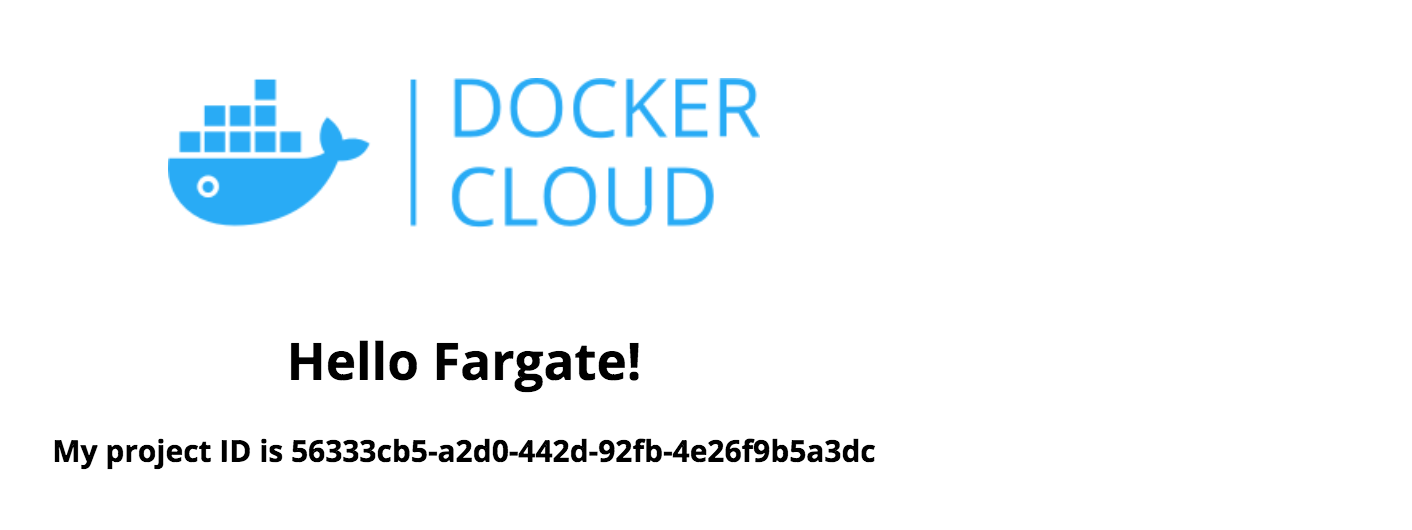